# Convolutional Neural Networks
This assignment aims to implement a CNN using the PyTorch deep learning framework.


You will learn how to prepare the data, define the model, train and test your model.

**Note**:
- If you do not have sufficient computational power (i.e., no access to GPU), please use Google Collab for this assignment. It is a fairly easy to use Jupyter Notebook. Before running your code on Collab, go to ``Runtime`` $\rightarrow$ ``Change runtime type``, choose **GPU** on the dropdown menu and ``Save``.

**Overview:**
- Data Processing:
    - Data Normalization/Standardization
    - Data Augmentation
- Architectures:
    - Design and train a CNN model
    - **[LeNet](https://www.wikiwand.com/en/LeNet)** and **[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)** are recommended as references.
    - Other architectures, i.e. ResNet, VGG, Inception are also suggested (but may require more computational expense).
    - Regularization
        - Dropout
        - L2 Norm
        - etc.
- Hyperparameter tuning:
    - Learning rate:
        - Try at least **three different** learning rates.
    - Optimizer:
        - Try at least **three different** optimizers, e.g. *SGD, RMSprop, Adam* and *etc*.

## 1 - Packages
Import the necessary packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
%matplotlib inline

## 2 - Training Parameters
Define some hyper-parameters for the training process. Try changing these hyper-parameters and observe the performance of the model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # using gpu or cpu
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
num_classes = 10 # number of classes
batch_size = 100
num_epochs = 20 # to get a better result, you can increase the number of epochs

learning_rate = 0.001 # suggested range [1e-2, 1e-4]


## 3 - Data Loader and Augmentation
We will use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) as our dataset. Pytorch provide functions to download this dataset, you don't have to do download it from the official website. In this section, you will become familiar with the data loading pipeline of PyTorch.

- Normalize all the images to help remove gross bias within the data and to place us numerically within a known range for any input data.

- Implement data augmentations for the training see (see more [here](https://pytorch.org/vision/stable/transforms.html)):
    - RandomCrop, RandomHorizontalFlip, RandomRotation, etc.
    
- More info [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [ ]:
# Data augmentation
transform_train = transforms.Compose([
    ### START CODE HERE ### (≈ 3 lines of code)
    # Fill in data augmentations
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    ### END CODE HERE ###
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Don't augment the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


## 4 - Define the Networks
This section defines the architecture of the network. We provide the output dimension of each layer's output. Use this information to define the appropriate convolutional, max pooling and fully-connected (linear) layers in PyTorch with the code skeleton provided below. There might be multiple solutions to achieve the specified dimensions; it is required that the number of parameters in the network cannot exceed 3 million. We provide a code segment for you to check the number of parameters below. Here, m denotes the batch size. The forward pass is also defined.

- Input: (m, 3, 32, 32)
- After ``conv1``: (m, 64, 16, 16)
- After ``maxpool1``: (m, 64, 8, 8)
- After ``conv2``: (m, 192, 8, 8)
- After ``maxpool2``: (m, 192, 4, 4)
- After ``conv3``: (m, 384, 4, 4)
- After ``maxpool3``: (m, 384, 2, 2)
- After ``conv4``: (m, 256, 2, 2)
- After ``maxpool4``: (m, 256, 1, 1)
- After ``fc1``: (m, 512)
- After ``fc2``: (m, 512)
- After ``fc3`` (Output): (m, 10)

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def observe_outputs(self, x): # used to observe the dimension of each layer's output

        ### START CODE HERE ###
        # Print the size of each layer's output
        print("Input shape:", x.shape)
        x = self.maxpool1(F.relu(self.conv1(x)))
        print("After conv1 & maxpool1:", x.shape)
        x = self.maxpool2(F.relu(self.conv2(x)))
        print("After conv2 & maxpool2:", x.shape)
        x = self.maxpool3(F.relu(self.conv3(x)))
        print("After conv3 & maxpool3:", x.shape)
        x = self.maxpool4(F.relu(self.conv4(x)))
        print("After conv4 & maxpool4:", x.shape)
        x = x.view(x.size(0), -1)
        print("After flatten:", x.shape)
        x = F.relu(self.fc1(x))
        print("After fc1:", x.shape)
        x = F.relu(self.fc2(x))
        print("After fc2:", x.shape)
        x = self.fc3(x)
        print("After fc3 (Output):", x.shape)

        ### END CODE HERE ###

        return x

    def forward(self, x):

        ### START CODE HERE ###
        # Implement forward pass for each layer
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = self.maxpool3(F.relu(self.conv3(x)))
        x = self.maxpool4(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        ### END CODE HERE ###

        return x


Run the block of code below to confirm each layer's output dimension matches the requirements.

In [ ]:
def test_forward(): # This function displays each layer's output dimension
    model = Model().to(device)
    x = torch.randn(16, 3, 32, 32).to(device)
    with torch.no_grad():
        model.observe_outputs(x)

test_forward()


Input shape: torch.Size([16, 3, 32, 32])
After conv1 & maxpool1: torch.Size([16, 64, 16, 16])
After conv2 & maxpool2: torch.Size([16, 192, 8, 8])
After conv3 & maxpool3: torch.Size([16, 384, 4, 4])
After conv4 & maxpool4: torch.Size([16, 256, 2, 2])
After flatten: torch.Size([16, 1024])
After fc1: torch.Size([16, 512])
After fc2: torch.Size([16, 512])
After fc3 (Output): torch.Size([16, 10])


Run the block of code below to confirm your network has fewer than 30 millions parameters.

In [ ]:
def count_parameters(net, all=True):
    # If all == False, we only return the trainable parameters
    return sum(p.numel() for p in net.parameters() if p.requires_grad or all)

num_params = count_parameters(Model())
print(f'Total number of parameters: {num_params}')


Total number of parameters: 2454090


## 5 - Loss and Optimizer
This section initializes the ``Model`` class, and defines the loss function and optimizer. We are doing multi-class classification, so we use the cross-entropy loss. The standard optimizers are Stochastic Gradient Descent (SGD) and Adam. You can find more optimizers [here](https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer).

In [ ]:
# initialize the model and send it to GPU using torch.Tensor.to()
model = Model().to(device)

# initialize cross-entropy loss
criterion = nn.CrossEntropyLoss()

# initialize Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## 6 - Define the Training Loop
This section will learn how to train the model: get batches, calculate loss, and update model.

A standard PyTorch training loop consists of:

- Getting the prediction for each batch.
- Calculate the loss on the prediction versus the true label (ground truth).
- Calculate the gradients.
- Update the model's weights/parameters using the optimizer and the gradients computed in the previous step.

Also, do not forget to (optional):

- Keep track of the loss values to plot the training loss later
- Clear out the old gradients in the optimizer every iteration before calculating the new ones.
- Frequently print out the accuracy of the model to see if the learning is on the right track.

Please fill in the missing codes.

In [ ]:
# Train the model
def train(epoch):
    print('\nEpoch: %d' % epoch)
    train_losses = [] # needed for visualize the traning loss
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)# get a batch
        ### START CODE HERE ### (≈ 5 lines of code)
        # Clear gradient
        optimizer.zero_grad()
        # Forward pass batch through model
        outputs = model(inputs)
        # Calculate loss on batch
        loss = criterion(outputs, targets)
        # Calculate gradients for backward pass
        loss.backward()
        # Update model
        optimizer.step()
        ### END CODE HERE ###

        train_loss += loss.item()
        train_losses.append(loss.item())
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 0: # print every 100 iterations
            print(batch_idx, len(trainloader), 'Train Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_losses


## 7 - Define the Testing Loop
This section will learn how to test the trained model and save the best model.

A standard PyTorch testing loop consists of:

- Getting the predictions and calculate the accuracy over the whole testing set.

Do not forget to:

- Disable the gradients on the model upon making predictions (i.e., ``torch.no_grad()``).
- Save the best model's weights ([reference](https://pytorch.org/tutorials/beginner/saving_loading_models.html)).

Please fill in the missing codes.

In [ ]:
def test(epoch):
    global best_acc
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            ### START CODE HERE ### (≈ 2 lines of code)
            # Forward pass batch through model
            outputs = model(inputs)
            # Calculate loss on batch
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_losses.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 100 == 0:
                print(batch_idx, len(testloader), 'Testing Loss: %.3f | Acc: %.3f%% (%d/%d)'
                            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save best model.
    acc = 100.*correct/total
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(acc))
    if acc > best_acc:
        print('Start Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
        print('Done Saving!')
    return test_losses


## 8 - Model Training and Testing

Run the training and testing loops to conduct the training process.

In [ ]:
for epoch in range(start_epoch, start_epoch + num_epochs):
    l_tr = train(epoch)
    l_te = test(epoch)



Epoch: 0
0 500 Train Loss: 2.304 | Acc: 9.000% (9/100)
100 500 Train Loss: 2.005 | Acc: 23.584% (2382/10100)
200 500 Train Loss: 1.866 | Acc: 29.109% (5851/20100)
300 500 Train Loss: 1.776 | Acc: 32.834% (9883/30100)
400 500 Train Loss: 1.701 | Acc: 35.968% (14423/40100)
0 100 Testing Loss: 1.371 | Acc: 54.000% (54/100)
Test Accuracy of the model on the 10000 test images: 50.95 %
Start Saving..
Done Saving!

Epoch: 1
0 500 Train Loss: 1.317 | Acc: 53.000% (53/100)
100 500 Train Loss: 1.324 | Acc: 52.257% (5278/10100)
200 500 Train Loss: 1.299 | Acc: 52.935% (10640/20100)
300 500 Train Loss: 1.270 | Acc: 53.990% (16251/30100)
400 500 Train Loss: 1.250 | Acc: 54.751% (21955/40100)
0 100 Testing Loss: 1.015 | Acc: 63.000% (63/100)
Test Accuracy of the model on the 10000 test images: 61.77 %
Start Saving..
Done Saving!

Epoch: 2
0 500 Train Loss: 1.036 | Acc: 62.000% (62/100)
100 500 Train Loss: 1.110 | Acc: 60.050% (6065/10100)
200 500 Train Loss: 1.090 | Acc: 61.085% (12278/20100)
300 5

## 9 - Report your Results

- You have to report the followings in a separate PDF:
    - The number of parameters in your CNN.
    - The best accuracy on the testing set (along with the training training set). You will get full credit if your model achieves $ > 70\%$ accuracy on the testing set.
    - F1 score on the testing set from the model with the best accuracy. There is no provided code for this; please implement F1 score.
    - A plot containing the **training and testing accuracies** with respect to time (epochs).
    - A plot containing the **training and testing losses** with respect to time (epochs).
    - Try 2 more learning rates with the Adam optimizer and report the accuracy and F1 score for both.
    - Try 2 more optimizers with a fixed learning rate of 0.01 and report the accuracy and F1 score for both.
    - Trying different learning rates and optimizers is also known as Ablation Study. Organize your results in a table for ease of readability. Please give some insights on the performances of different settings.
    - Finally, please submit the notebook **that contains the output logs**.

## Extra - Evaluation from Checkpoint (Optional)
This section will show you how to load the saved model.

In [ ]:
checkpoint = torch.load('./checkpoint/ckpt.pth') # load checkpoint
model.load_state_dict(checkpoint['net']) # load model parameter

model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        ### START CODE HERE ### (≈ 2 lines of code)
        # Forward pass real batch through model
        outputs = model(inputs)
        # Calculate loss on all-real batch
        loss = criterion(outputs, targets)

        ### END CODE HERE ###

        test_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
acc = 100.*correct/total
print('Test Accuracy of the model on the 10000 test images: {} %'.format(acc))


<ipython-input-33-facb9fe46b03>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint/ckpt.pth') # load checkpoint


Test Accuracy of the model on the 10000 test images: 81.55 %


## Extra - Plot the Training Loss  

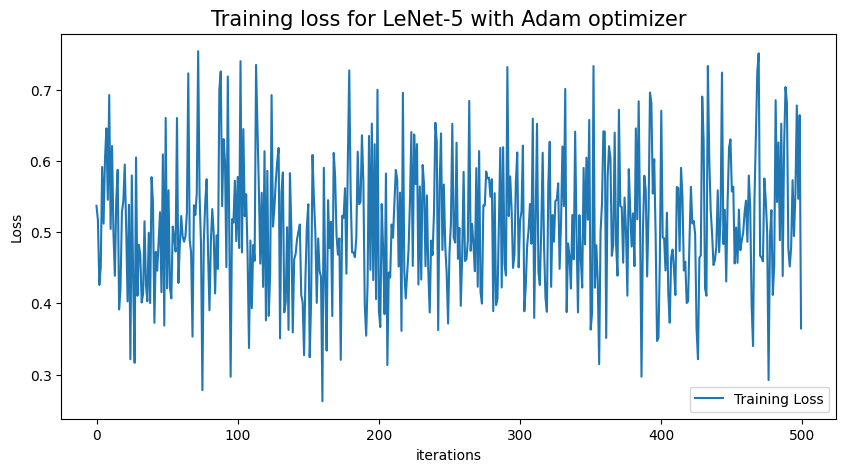

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.title("Training loss for LeNet-5 with Adam optimizer", fontsize=15)
plt.plot(l_tr,label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
#ax.text(0.7, 0.7,'Test ACC: 64.35%; lr=1e-3',
     #horizontalalignment='center',
     #verticalalignment='center',
     #transform = ax.transAxes,
     #fontsize=20, color='red')
plt.legend()
plt.show()


#The number of parameters in your CNN.

In [ ]:
# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')


Total number of parameters: 2454090


#F1 Score
F1 score on the testing set from the model with the best accuracy. There is no provided code for this; please implement F1 score.

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Define the function to calculate F1 score
def calculate_f1_score(model, testloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions (class with highest probability)
            _, predicted = outputs.max(1)

            # Append predictions and true labels
            all_preds.extend(predicted.cpu().numpy())  # Move to CPU for sklearn compatibility
            all_labels.extend(targets.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return f1

# Load the best model from the checkpoint
checkpoint = torch.load('./checkpoint/ckpt.pth')
model.load_state_dict(checkpoint['net'])

# Calculate F1 score on the test set
test_f1 = calculate_f1_score(model, testloader, device)
print(f'Testing F1 Score: {test_f1:.4f}')


<ipython-input-40-03056667465a>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint/ckpt.pth')


Testing F1 Score: 0.8171


#Plot Train & Test acuuracies and loss
A plot containing the training and testing accuracies with respect to time (epochs).

A plot containing the training and testing losses with respect to time (epochs).

In [ ]:
# Train the model and track the accuracy and loss for each epoch
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_accuracy = 100.*correct/total
    avg_train_loss = train_loss / len(trainloader)

    return avg_train_loss, train_accuracy

# Test the model and track the accuracy and loss for each epoch
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    test_accuracy = 100.*correct/total
    avg_test_loss = test_loss / len(testloader)

    # Save the best model
    acc = test_accuracy
    if acc > best_acc:
        print('Saving model...')
        state = {'net': model.state_dict(), 'acc': acc, 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
        print('Model saved!')

    return avg_test_loss, test_accuracy


In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(start_epoch, start_epoch + num_epochs):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)

    # Append the losses and accuracies for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)



Epoch: 0
Saving model...
Model saved!

Epoch: 1
Saving model...
Model saved!

Epoch: 2

Epoch: 3
Saving model...
Model saved!

Epoch: 4

Epoch: 5

Epoch: 6
Saving model...
Model saved!

Epoch: 7

Epoch: 8
Saving model...
Model saved!

Epoch: 9
Saving model...
Model saved!

Epoch: 10

Epoch: 11
Saving model...
Model saved!

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15
Saving model...
Model saved!

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19
Saving model...
Model saved!


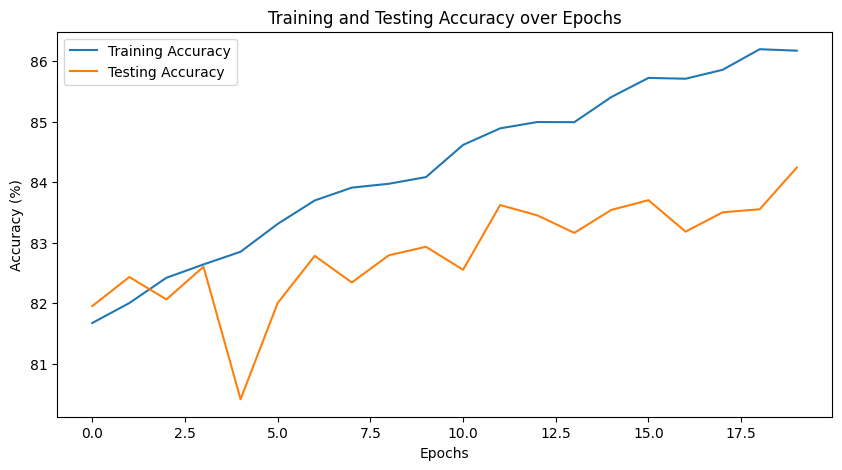

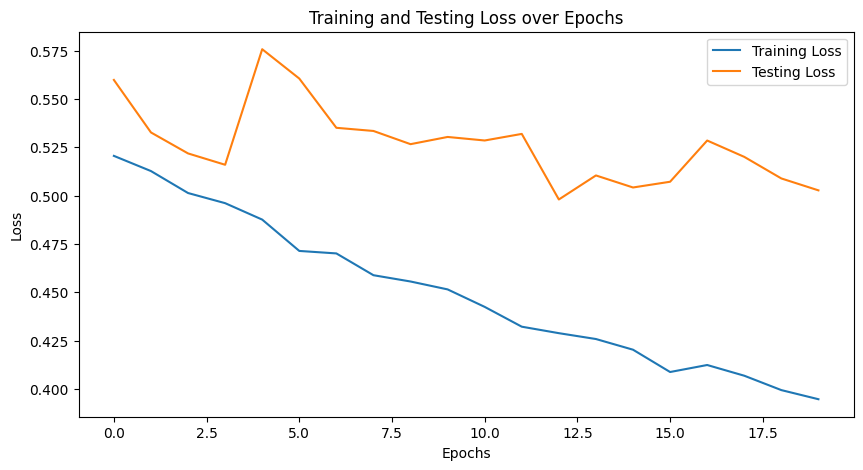

In [ ]:
# Plot Training and Testing Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Plot Training and Testing Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), test_losses, label='Testing Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Try 2 more learning rates with the Adam optimizer and report the accuracy and F1 score for both.

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Define the function to calculate F1 score
def calculate_f1_score(model, testloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return f1

# Function to train the model with a specific learning rate
def train_and_evaluate_model(learning_rate, trainloader, testloader, device, num_epochs=20):
    model = Model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    for epoch in range(num_epochs):
        train_loss = train(epoch)
        test_loss = test(epoch)

    # Evaluate the model's accuracy and F1 score
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    f1 = calculate_f1_score(model, testloader, device)

    return acc, f1

# Try two different learning rates and evaluate the performance
learning_rates = [0.0001, 0.0005]  # New learning rates to try

for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr}")
    acc, f1 = train_and_evaluate_model(lr, trainloader, testloader, device)
    print(f"Accuracy: {acc:.2f}% | F1 Score: {f1:.4f}")



Training with Learning Rate: 0.0001

Epoch: 0
Saving model...
Model saved!

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10
Saving model...
Model saved!

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19
Accuracy: 10.00% | F1 Score: 0.0182

Training with Learning Rate: 0.0005

Epoch: 0

Epoch: 1

Epoch: 2

Epoch: 3
Saving model...
Model saved!

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16
Saving model...
Model saved!

Epoch: 17

Epoch: 18

Epoch: 19
Accuracy: 10.00% | F1 Score: 0.0182


#Try 2 more optimizers with a fixed learning rate of 0.01 and report the accuracy and F1 score for both.

In [ ]:
from sklearn.metrics import f1_score
import torch.optim as optim

# Function to train the model with a specific optimizer
def train_and_evaluate_optimizer(optimizer_type, learning_rate, trainloader, testloader, device, num_epochs=20):
    model = Model().to(device)

    # Choose optimizer based on the input argument
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type.")

    criterion = nn.CrossEntropyLoss()

    # Train the model
    for epoch in range(num_epochs):
        train_loss = train(epoch)
        test_loss = test(epoch)

    # Evaluate the model's accuracy and F1 score
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    f1 = calculate_f1_score(model, testloader, device)

    return acc, f1

# Try two different optimizers with a fixed learning rate of 0.01 and evaluate the performance
learning_rate = 0.01
optimizers = ['SGD', 'RMSprop']  # Optimizers to try

for opt in optimizers:
    print(f"\nTraining with Optimizer: {opt} and Learning Rate: {learning_rate}")
    acc, f1 = train_and_evaluate_optimizer(opt, learning_rate, trainloader, testloader, device)
    print(f"Accuracy: {acc:.2f}% | F1 Score: {f1:.4f}")



Training with Optimizer: SGD and Learning Rate: 0.01

Epoch: 0

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19
Saving model...
Model saved!
Accuracy: 10.00% | F1 Score: 0.0192

Training with Optimizer: RMSprop and Learning Rate: 0.01

Epoch: 0

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19
Accuracy: 10.00% | F1 Score: 0.0182
